In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from apyori import apriori
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,AgglomerativeClustering,Birch
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics.cluster import adjusted_rand_score

In [1]:
pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-cp37-none-any.whl size=5979 sha256=50d9abbf057b2361127f82d0ed592cedf017be66ce7d5a8efa6ab5a3267e75cb
  Stored in directory: C:\Users\Admin\AppData\Local\pip\Cache\wheels\5d\92\bb\474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori
Note: you may need to restart the kernel to use updated packages.


In [2]:
SEED = 13
np.random.seed(SEED)

# Helpers

In [3]:
class EDA():
    '''
    Very basic EDA class to show the very basic nature of data. 
    dataframe is not required for the __init__() constructor to make it very generic.
    A pandas dataframe is required to be in every method.
    '''    
        
    
    def find_missing(self,df):
        '''
        Find the missing values by either looking at the np.nan() sum or by looking at minimum values which are not 
        supposed to be there such as height can not be 0 or negative
        '''
        
        print('Missing Values Count in each Column\n\n',df.isna().sum(),'\n')
        print('Check if missing value is replaced by 0\n\n',df.min(),'\n')
        print('Check unique values in each column\n\n',df.nunique(),'\n')
        
        
    def check_distribution(self,df,column_name):
        '''
        Checks the distribution of column in data given the column is categorical in nature.
        input:
            class_name: name of the column in dataframe
        out:
            display a pie chart with respective percentages of the classes 
        '''
    
        df[column_name].value_counts().plot(kind='pie',autopct='%1.2f%%', rotatelabels=True)
        
        
    def basic_plots(self,df,force=False,cols=3,PAD=3,width=15):
        '''
        if there are less than 15 features, it plots the basic plots to get the visualization of data. 
        If data is categorical, it plots the bar else the distribution for numerical. Last plot is always violin
        args:
            df: pandas dataframe
            force: whether to plot the who dataFrame
            cols: number of columns for the subplots
            PAD: padding for spacing of subplots
            width: change whole width of the graph
        '''
        rows=df.shape[1]//cols+1
        if (not force and df.shape[1]<=15) or force:
            f,ax = plt.subplots(nrows=rows,ncols=cols, figsize=(width,df.shape[1]+3))
            ax = ax.ravel()
            
            for i , column in enumerate(df.columns): # if purely categorical
                ax[i].set_xlabel(column)
                if df[column].dtypes == 'O': # class names a,b,c,d
                    df[column].value_counts().plot(kind='bar',ax=ax[i])
                
                else:
                    if df[column].nunique() < df.shape[0]//10: # classes 1,2,3,4
                        df[column].value_counts().plot(kind='bar',ax=ax[i])
                    else:
                        sns.distplot(df[column],ax=ax[i])
                
            
            for axis_num in range(i+1,(cols*rows)): # delete the remaining empty plots
                f.delaxes(ax[axis_num])
            
            plt.show()

        else: 
            print("There are more columns than allowed. Please pass 'force=True'")
            
            
    def vio_box(self,df):
        '''
        plot box and violin plots if there is atleast 1 numerical column
        args:
            df: pandas dataframe or numpy array
        '''
        f,ax = plt.subplots(1,2,figsize=(9,4))
        try:
            sns.boxplot(data=df,ax=ax[0])
            sns.violinplot(data=df,ax=ax[1])
        except:
            print('Not a single numerical column to plot the box or violin')
            f.delaxes(ax[0])
            f.delaxes(ax[1])
        plt.show()
            
    
    def pairplots(self,df):
        '''
        plot the pair-plots of the data using seaborn
        '''
            
        if df.shape[1]<=10:
            sns.pairplot(df)
    
    
    def fix_heatmap(self):
        '''
        fix the half cut upper and lower boxes of a heatmap in newer versions of Seaborn
        '''
        b, t = plt.ylim() # discover the values for bottom and top
        b += 0.5 # Add 0.5 to the bottom
        t -= 0.5 # Subtract 0.5 from the top
        plt.ylim(b, t) # update the ylim(bottom, top) values
        plt.show()

    
    def show_corr(self,df,plot=False):
        '''
        Show the correlation within a dataframe
        args:
            df: pandas datadframe
            plot: {bool} default False. Whether to show the heatmap or not
        out:
            returns correlated squared DataFrame 
        '''
        
        if plot:
            sns.heatmap(df.corr(),annot=True, cmap='coolwarm',facecolor='b',lw=2)
            self.fix_heatmap()
            
        print(f'Correlation of each column:\n\n')
        return df.corr()    
        
        
    def classification_relation(self,df,col_name,cols=3,force=False,PAD=3,width=15):
        '''
        method to show the columns relations with the class. Can be used to see column to column if col_name is categorical
        args:
            df: pandas dataframe
            col_name: any categorical column whose relation/distribution we want to see with all the columns in that df
            rows: number of rows for subplots
            force: whether to show each and every column
            PAD: Padding for subplots spacing
            width: used for width of graph
        '''
        
        rows=df.shape[1]//cols+1
        if (not force and df.shape[1]<=15) or force:
            f,ax = plt.subplots(nrows=rows,ncols=cols, figsize=(width,df.shape[1]+PAD))
            ax = ax.ravel()
            
            for i , column in enumerate(df.columns): # if purely categorical
                ax[i].set_xlabel(column)
                if df[column].dtypes == 'O': # class names a,b,c,d
                    sns.countplot(x=column, hue=col_name, data=df,ax=ax[i])
                
                else:
                    if df[column].nunique() < df.shape[0]//10: # classes 1,2,3,4
                        sns.countplot(x=column, hue=col_name, data=df,ax=ax[i])
                        
                    else:
                        sns.stripplot(y=column, x=col_name,data=df,ax=ax[i])
                
            for axis_num in range(i+1,(cols*rows)): # delete the remaining empty plots
                f.delaxes(ax[axis_num])
            plt.show()

        else: 
            print("There are more columns than allowed. Please allow 'force=True'")
        

In [4]:
eda = EDA()

# Task 1

In [20]:
dataset = pd.read_csv('Groceries.csv',header=None)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
dataset.dropna(axis=1,thresh=dataset.shape[1]//3,inplace=True) # drop columns which have more than 66% values missing

In [22]:
dataset.shape

(9835, 23)

In [23]:
#transactions =  dataset.values.tolist()
transactions = []
for i in range(0, dataset.shape[0]):
    transactions.append([str(dataset.values[i,j]) for j in range(0, 23)])

In [24]:
rules = apriori(transactions, min_support = 0.003, min_confidence = 0.2, min_lift = 3, min_length = 2) 
result = list(rules)

In [25]:
for item in result:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: hamburger meat -> Instant food products
Support: 0.003050330452465684
Confidence: 0.379746835443038
Lift: 11.42143769597027
Rule: whipped/sour cream -> baking powder
Support: 0.004575495678698526
Confidence: 0.25862068965517243
Lift: 3.607850330154072
Rule: root vegetables -> beef
Support: 0.017386883579054397
Confidence: 0.3313953488372093
Lift: 3.0403668431100312
Rule: whipped/sour cream -> berries
Support: 0.009049313675648195
Confidence: 0.27217125382262997
Lift: 3.796885505454703
Rule: liquor -> bottled beer
Support: 0.004677173360447382
Confidence: 0.4220183486238532
Lift: 5.253861340146324
Rule: red/blush wine -> bottled beer
Support: 0.004880528723945094
Confidence: 0.253968253968254
Lift: 3.161744022503517
Rule: margarine -> flour
Support: 0.0036603965429588205
Confidence: 0.21176470588235294
Lift: 3.622097186700767
Rule: flour -> sugar
Support: 0.004880528723945094
Confidence: 0.28235294117647064
Lift: 8.364280652019845
Rule: whipped/sour cream -> flour
Support: 0.00396

```Support``` is an indication of how frequently the items appear in the data. Mathematically, support is the fraction of the total number of transactions in which the item set occurs.

```Confidence``` indicates the number of times the if-then statements are found true. Confidence is the conditional probability of occurrence of consequent given the antecedent.

```Lift``` can be used to compare confidence with expected confidence. This says how likely item Y is purchased when item X is purchased, while controlling for how popular item Y is.

# Task 2

## 2.2 Classification on Mushroom dataset

In [5]:
df_mush = pd.read_excel('Mushroom.xlsx')

In [6]:
df_mush.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
Class                       8124 non-null object
Cap-shape                   8124 non-null object
Cap-surface                 8124 non-null object
Cap-color                   8124 non-null object
Bruises                     8124 non-null object
Odor                        8124 non-null object
Gill-attachment             8124 non-null object
Gill-spacing                8124 non-null object
Gill-size                   8124 non-null object
Gill-color                  8124 non-null object
Stalk-shape                 8124 non-null object
Stalk-root                  8124 non-null object
Stalk-surface-above-ring    8124 non-null object
Stalk-surface-below-ring    8124 non-null object
Stalk-color-above-ring      8124 non-null object
Stalk-color-below-ring      8124 non-null object
Veil-type                   8124 non-null object
Veil-color                  8124 non-null object
Ring-number

Every column here is of type 'object' so it means that either the values as of type string or the integer are stored as the type such as 123 as '123'. There are 8124 records and 23 columns in total.

In [7]:
df_mush.head()

,Class,Cap-shape,Cap-surface,Cap-color,Bruises,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,...,Stalk-surface-below-ring,Stalk-color-above-ring,Stalk-color-below-ring,Veil-type,Veil-color,Ring-number,Ring-type,Spore-print-color,Population,Habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [8]:
df_mush.nunique()

Class                        2
Cap-shape                    6
Cap-surface                  4
Cap-color                   10
Bruises                      2
Odor                         9
Gill-attachment              2
Gill-spacing                 2
Gill-size                    2
Gill-color                  12
Stalk-shape                  2
Stalk-root                   5
Stalk-surface-above-ring     4
Stalk-surface-below-ring     4
Stalk-color-above-ring       9
Stalk-color-below-ring       9
Veil-type                    1
Veil-color                   4
Ring-number                  3
Ring-type                    5
Spore-print-color            9
Population                   6
Habitat                      7
dtype: int64

Class is the result label and there is variation within the dataset regarding the numberof categories.

In [9]:
df_mush.isnull().sum().sum()

0

No null values present as of now in any of the columns

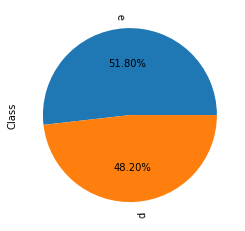

In [10]:
eda.check_distribution(df_mush,column_name='Class')

Distribution of classes are almost same so there is no need of sampling

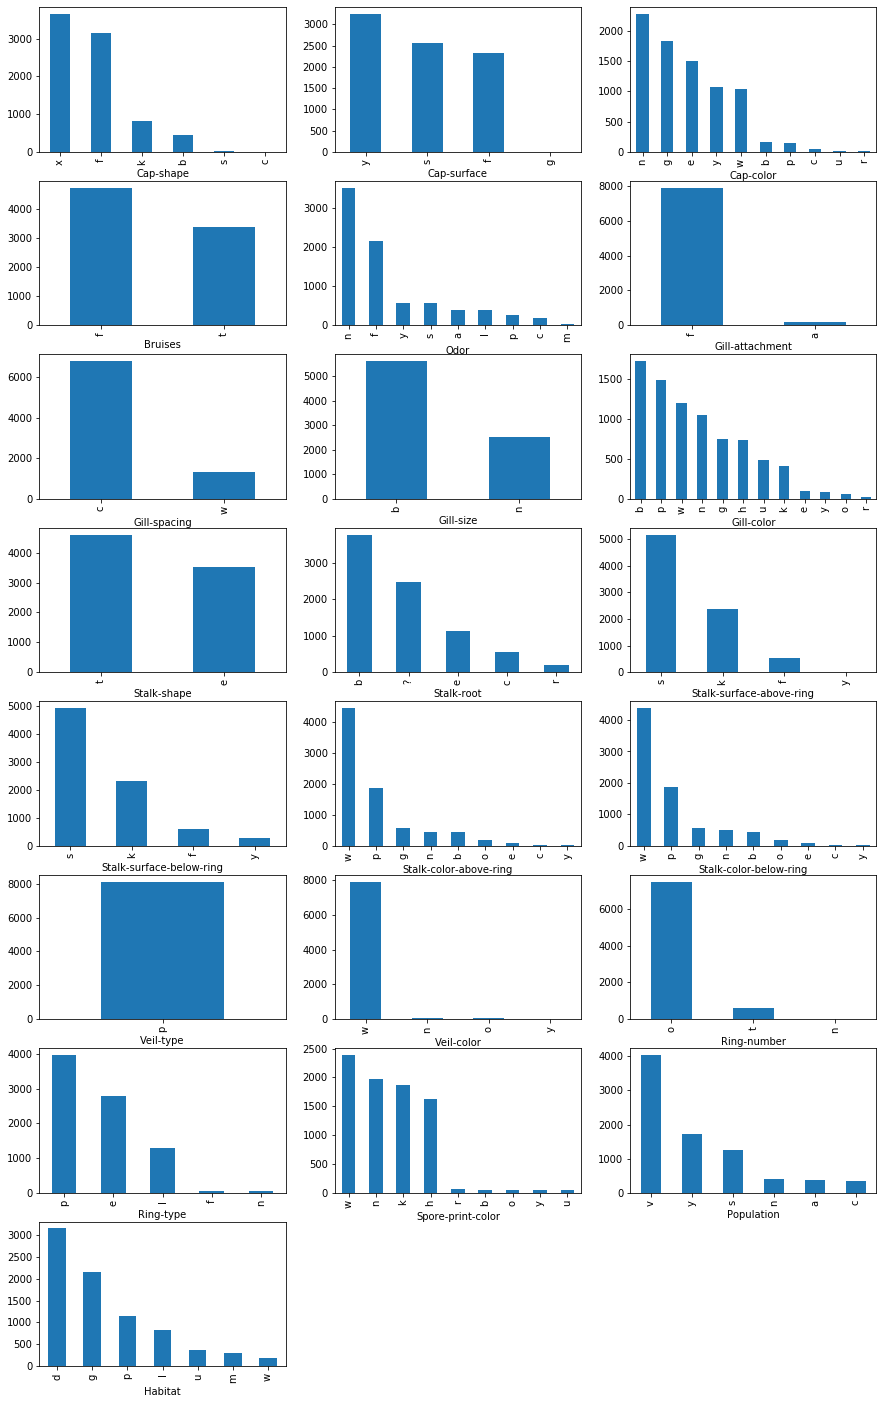

In [11]:
eda.basic_plots(df_mush.drop('Class',axis=1),force=True)

Plot tells us many things like all the columns are categorical in nature, we can easily drop veil_color,veil_type,Ring_number, Gill-attatchment and a few more because either they have just one class or the distribution of class is very high for some classes. If it is one one class only, there is no need to use the column as its existance does not affect our case and if the distribution is around 90-10 then it will just inflate the variance in the model

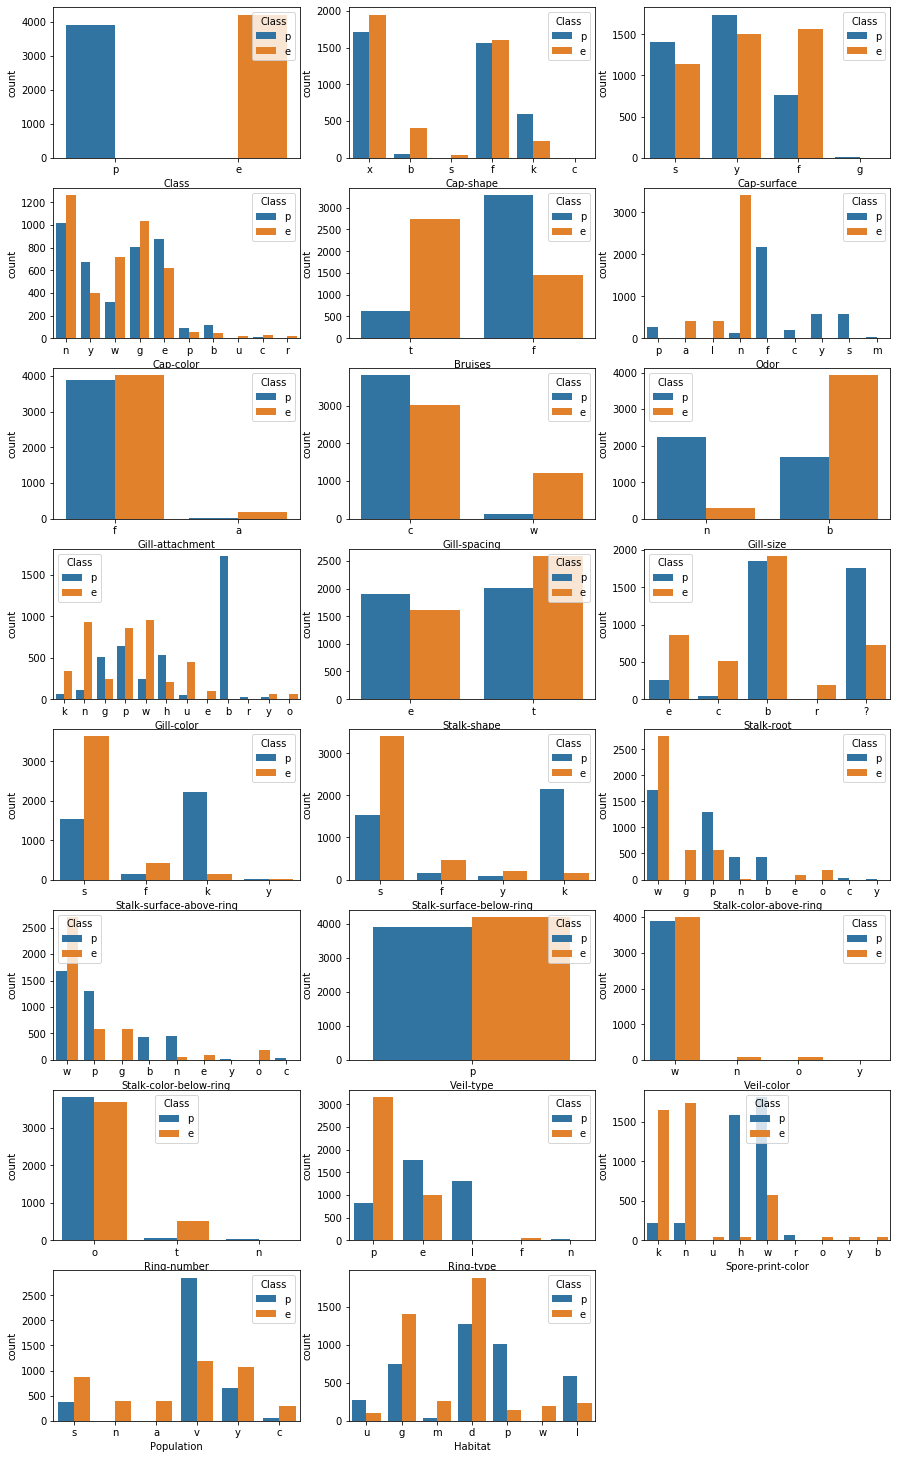

In [12]:
eda.classification_relation(df_mush,'Class',force=True)

This plot helps us in a ways in accordance to the class distribution with columns. for example if ```Veil-color``` has classeses ```n,o,y```, the result is definately going to be ```class e```. If ```Ring-number``` is ```n``` then it belongs to class ```p```. No ```l ring-type``` belongs to class ```e``` so it is safe to assume that any mushroom which has ring type of ```l``` it is definately going to be class e

## Processing Data

In [13]:
df_mush['Class'].replace({'e':0,'p':1},inplace=True) # binary encode

In [14]:
X = df_mush.drop('Class',axis=1)
y = df_mush['Class'].values

In [15]:
X = pd.get_dummies(X,drop_first=True) # drop a column because value of Nth column can be found by using N-1 columns

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X.values,y,test_size=0.2, random_state=SEED)

In [17]:
np.bincount(y_train) # almost same number of claasses in training data

array([3366, 3133], dtype=int64)

### Base Model {Logistic Regression}

In [18]:
log = LogisticRegression()
clf = log.fit(X_train,y_train)
clf.score(X_train,y_train)

1.0

In [19]:
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



Base Linear Logistic Regression Model is able to classify the data perfectly

### Bayes Classifier (Gauss)

In [20]:
gauss = GaussianNB()
clf = gauss.fit(X_train,y_train)
clf.score(X_train,y_train)

0.9446068625942453

In [21]:
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       842
           1       0.91      1.00      0.95       783

    accuracy                           0.95      1625
   macro avg       0.96      0.96      0.95      1625
weighted avg       0.96      0.95      0.95      1625



Classifier is able to classify the data with an f1 score of 0.95 and precision of 0.96 and recall of 0.96. So we can say it is not a good model as it performed worse than the base model

### Decision Tree

In [22]:
tree = DecisionTreeClassifier(random_state=SEED)
clf = tree.fit(X_train,y_train)

In [23]:
clf.score(X_train,y_train)

1.0

In [24]:
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



Our classifier is able to classify the data to a complete precision, accuracy and recall of 1

## Clustering

### Base Model (K - Mean Clustering)

In [25]:
k_mean = KMeans(n_clusters=2)
clf = k_mean.fit(X_train)
y_kmeans = clf.predict(X_train)

It is an average score to have but can be better

In [26]:
from sklearn.decomposition import PCA

In [27]:
X = PCA(n_components=2).fit_transform(X_train)

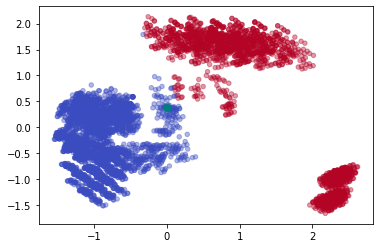

In [28]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=20, cmap='coolwarm',facecolor='none',alpha=0.4)

centers = k_mean.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='teal', s=50, alpha=0.8);

### BIRCH

In [29]:
birch  = Birch(n_clusters=2)
clf = birch.fit(X_train)
y_birch = clf.predict(X_train)

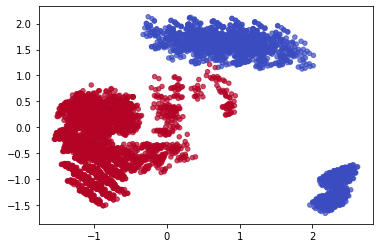

In [30]:
plt.scatter(X[:, 0], X[:, 1], c=y_birch, s=20, cmap='coolwarm',facecolor='none',alpha=0.7)

### Agglomerative

In [31]:
agg = AgglomerativeClustering(n_clusters=2).fit(X_train)
y_agg = agg.labels_

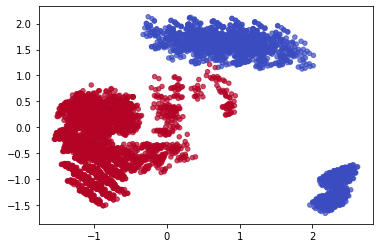

In [32]:
plt.scatter(X[:, 0], X[:, 1], c=y_agg, s=20, cmap='coolwarm',facecolor='none',alpha=0.7)